In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset
from wangdao_deeplearning_train import EarlyStopping, ModelSaver
from wangdao_deeplearning_train import plot_learning_curves,plot_learning_loss_curves
import os

In [3]:
# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 加载加利福尼亚房价数据集
housing = fetch_california_housing()
X = housing.data
y = housing.target

# 数据拆分：训练集(60%)、验证集(20%)、测试集(20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)  # 0.25 x 0.8 = 0.2

print(f"训练集大小: {X_train.shape[0]}")
print(f"验证集大小: {X_val.shape[0]}")
print(f"测试集大小: {X_test.shape[0]}")

# 数据标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 自定义数据集类
class HousingDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets).view(-1, 1)
        
    def __len__(self):
        return len(self.features) #返回样本数量
    
    def __getitem__(self, idx): #传入索引，返回对应索引样本的特征和目标
        return self.features[idx], self.targets[idx]

# 创建数据集实例
train_dataset = HousingDataset(X_train_scaled, y_train)
val_dataset = HousingDataset(X_val_scaled, y_val)
test_dataset = HousingDataset(X_test_scaled, y_test)

训练集大小: 13209
验证集大小: 3303
测试集大小: 4128


# 加载数据，构建模型

In [4]:
from torch import optim
# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# 定义神经网络模型
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 30) # 线性层
        self.activation = nn.ReLU() # 激活函数
        self.output = nn.Linear(30, 1) # 输出层
        
    def forward(self, x):
        x = self.activation(self.layer1(x)) # 激活函数
        x = self.output(x)
        return x

# 初始化模型、损失函数和优化器
input_dim = X_train.shape[1]
model = RegressionModel(input_dim) # 模型
criterion = nn.MSELoss() # 损失函数
optimizer = optim.Adam(model.parameters()) # 优化器

# 打印模型结构
print(model)

RegressionModel(
  (layer1): Linear(in_features=8, out_features=30, bias=True)
  (activation): ReLU()
  (output): Linear(in_features=30, out_features=1, bias=True)
)


In [5]:
# 评估模型
def evaluate_regression_model(model, dataloader,  device,criterion):
    model.eval()
    running_loss = 0.0

    
    with torch.no_grad():#禁止 autograd 记录计算图，节省显存与算力。
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs) #前向计算
            loss = criterion(outputs, targets) #计算损失
            
            running_loss += loss.item() * inputs.size(0) # 计算总损失
    return running_loss / len(dataloader.dataset) # 计算平均损失

In [6]:
# 定义回归模型训练函数
def train_regression_model(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    device='cpu', 
    num_epochs=100, 
    print_every=10,
    eval_step=500,
    model_saver=None,
    early_stopping=None
):
    """
    训练回归模型的函数
    
    参数:
        model: 要训练的模型
        train_loader: 训练数据加载器
        val_loader: 验证数据加载器
        criterion: 损失函数
        optimizer: 优化器
        device: 训练设备
        num_epochs: 训练轮次
        print_every: 每多少轮打印一次结果
        eval_step: 每多少步评估一次
    
    返回:
        record_dict: 包含训练和验证记录的字典
    """
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0 # 全局步数
    model.train()
    epoch_val_loss=0 # 验证损失
    
    with tqdm(total=num_epochs * len(train_loader), desc="train progress") as pbar: 
        for epoch_id in range(num_epochs):
            # 训练
            model.train()
            running_loss = 0.0
            
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                
                # 梯度清空
                optimizer.zero_grad()
                
                # 模型前向计算
                outputs = model(inputs)
                
                # 计算损失
                loss = criterion(outputs, targets)
                
                # 梯度回传，计算梯度
                loss.backward()
                
                # 更新模型参数
                optimizer.step()
                
                # 更新步骤
                global_step += 1
            
                # 在每个批次后记录训练损失
                epoch_train_loss = loss.item()
                record_dict["train"].append({
                    "loss": epoch_train_loss,
                    "step": global_step
                })
                
                # 验证
                if global_step % eval_step == 0: # 每多少步评估一次
                    epoch_val_loss = evaluate_regression_model(model, val_loader, device, criterion) # 评估模型
            
                    # 记录验证数据
                    record_dict["val"].append({
                        "loss": epoch_val_loss, 
                        "step": global_step
                    })
                    # 保存模型权重
                    # 如果有模型保存器，保存模型
                    if model_saver is not None:
                        model_saver(model, -epoch_val_loss, epoch_id) 
                    
                    # 如果有早停器，检查是否应该早停
                    if early_stopping is not None:
                        early_stopping(-epoch_val_loss)
                        if early_stopping.early_stop:
                            print(f'早停: 已有{early_stopping.patience}轮验证损失没有改善！')
                            return model,record_dict
            
                # 更新进度条
                pbar.update(1)
                pbar.set_postfix({"loss": f"{epoch_train_loss:.4f}", "val_loss": f"{epoch_val_loss:.4f},global_step{global_step}"}) 
    
    return model, record_dict


# 训练模型
# 初始化早停和模型保存对象
early_stopping = EarlyStopping(patience=10, verbose=True)
model_saver = ModelSaver(save_dir='model_weights')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=model.to(device)
model, record_dict = train_regression_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=100,
    print_every=10,
    eval_step=500,
    early_stopping=early_stopping,
    model_saver=model_saver,
    device=device
)

train progress:   0%|          | 0/41300 [00:00<?, ?it/s]

早停触发! 最佳验证准确率: -0.3335
早停: 已有10轮验证损失没有改善！


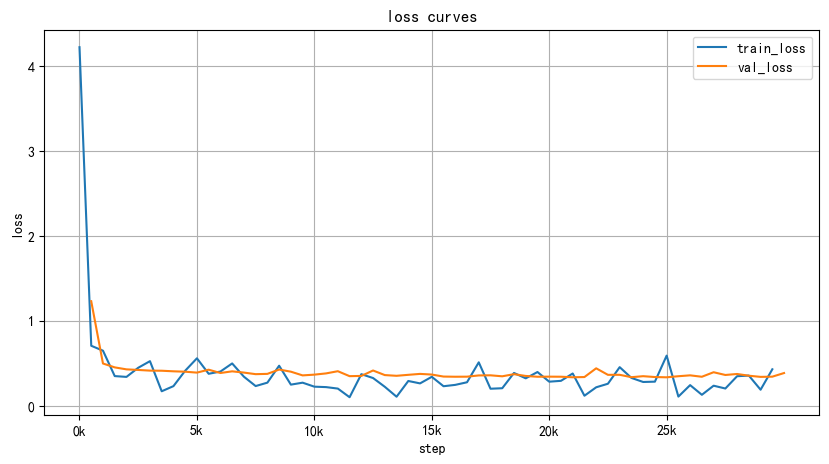

In [9]:
#画图
plot_learning_loss_curves(record_dict,sample_step=500)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_loss=evaluate_regression_model(model,test_loader,device,criterion)
print(f"测试集上的损失为{test_loss:.4f}")

测试集上的损失为0.3284
